# Cats and Dogs

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR_yYgUEkL3Zfer7aMmCUIpjNYmDUpwe1U4ew&usqp=CAU" width=600 >

# A Base de dados

Para o desenvolvimento do projeto será utilizado o dataset [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

# O Problema

- Gerar um classificador de gatos e cachorros

- Gerar um classificado de raças de animais
Obs: Ao invés de um problema binário, a base de dados será utilizada para classificar raças de animais, sendo cada raça uma classe.

# Índice

1. [Ferramentas](#1.-Ferramentas)

    1.1 [Importando as bibliotecas](#1.1-Importando-as-bibliotecas)
     
    1.2 [Funções auxiliares](#1.2-Funções-auxiliares)
    

2. [Preprocessamentos](#2.-Preprocessamentos)

    2.1 [Preparando as pastas](#2.1-Preparando-as-pastas)

      2.1.1 [Preparação para o Deep Learning](#2.1.1-Preparação-para-o-Deep-Learning)

      2.1.2 [Preparando os dados para o Random Florest](#2.1.2-Preparando-os-dados-para-o-Random-Florest)
      

3. [Modelos](#3.-Modelos)

    3.1 [Treinando o Random Florest](#3.1-Treinando-o-Random-Florest)

      3.1.1[Ajuste do modelo](#3.1.1-Ajuste-do-modelo)

    3.2 [Treinando a Rede](#3.2-Treinando-a-Rede)

      3.2.1 [Aplicando o modelo](#3.2.1-Aplicando-o-modelo)
      

4. [AVALIÇÃO DAS RAÇAS](#4.-AVALIÇÃO-DAS-RAÇAS)

    4.1 [Preparando as pastas](#4.1-Preparando-as-pastas)

    4.2 [Dogs](#4.2-Dogs)

      4.2.1 [Treinando a Rede](#4.2.1-Treinando-a-Rede)

      4.2.2 [Aplicando o modelo](#4.2.2-Aplicando-o-modelo)

    4.3 [Cats](#4.3-Cats)

      4.3.1 [Treinando a Rede](#4.3.1-Treinando-a-Rede)

      4.3.2 [Aplicando o modelo](#4.3.2-Aplicando-o-modelo)

# 1. Ferramentas

## 1.1 Importando as bibliotecas 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import glob
import random
import shutil

from skimage import feature

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D,MaxPooling2D, MaxPool2D, Flatten
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold



## 1.2 Funções auxiliares

In [3]:
def showMultipleImages(imgsArray, titlesArray, size, x, y):
    
    if(x < 1 or y < 1):
        print("ERRO: X e Y não podem ser zero ou abaixo de zero!")
        return
    elif(x == 1 and y == 1):
        showSingleImage(imgsArray, titlesArray)
    elif(x == 1):
        fig, axis = plt.subplots(y, figsize = size)
        yId = 0
        for img in imgsArray:
            axis[yId].imshow(img, 'gray')
            axis[yId].set_anchor('NW')
            axis[yId].set_title(titlesArray[yId], fontdict = {'fontsize': 18, 'fontweight': 'medium'}, pad = 10)

            yId += 1
    elif(y == 1):
        fig, axis = plt.subplots(1, x, figsize = size)
        fig.suptitle(titlesArray)
        xId = 0
        for img in imgsArray:
            axis[xId].imshow(img, 'gray')
            axis[xId].set_anchor('NW')
            axis[xId].set_title(titlesArray[xId], fontdict = {'fontsize': 18, 'fontweight': 'medium'}, pad = 10)

            xId += 1
    else:
        fig, axis = plt.subplots(y, x, figsize = size)
        xId, yId, titleId = 0, 0, 0
        for img in imgsArray:
            axis[yId, xId].set_title(titlesArray[titleId], fontdict = {'fontsize': 18, 'fontweight': 'medium'}, pad = 10)
            axis[yId, xId].set_anchor('NW')
            axis[yId, xId].imshow(img, 'gray')
            if(len(titlesArray[titleId]) == 0):
                axis[yId, xId].axis('off')

            titleId += 1
            xId += 1
            if xId == x:
                xId = 0
                yId += 1
    plt.show()

    
def moveImagesToCorrectFolder():
    
    percent_val = 0.10
    percent_test = 0.20
    files = glob.glob(original_path + '*')
    dog_train_files = []
    cat_train_files = []
    
    for file in files:
        if file.split('\\')[-1][0] == file.split('\\')[-1][0].upper():
            cat_train_files.append(file)
        else:
            dog_train_files.append(file)
    

    
    for f in dog_train_files:
        rand_val = random.random()
        filename = f.split("\\")[-1] 
        if rand_val <= percent_val: 
            shutil.move(f, new_folder_val_dogs + "\\" + filename) 
        elif rand_val > percent_val and rand_val <= percent_val + percent_test:
            shutil.move(f, new_folder_test_dogs + "\\" + filename) 
        else:
            shutil.move(f, new_folder_train_dogs + "\\" + filename) 
   
    for f in cat_train_files:
        rand_val = random.random()
        filename = f.split("\\")[-1] 
        if rand_val <= percent_val: 
            shutil.move(f, new_folder_val_cats + "\\" + filename) 
        elif rand_val > percent_val and rand_val <= percent_val + percent_test:
            shutil.move(f, new_folder_test_cats + "\\" + filename) 
        else:
            shutil.move(f, new_folder_train_cats + "\\" + filename) 


def moveImagesToCorrectFolder2():
    
    files = glob.glob(original_path + '*')
    dog_breed = []
    cat_breed = []
    
    for file in files:
        if file.split('\\')[-1].split('_')[0][0] == file.split('\\')[-1].split('_')[0][0].upper():
            if file.split('\\')[-1].split('_')[0] not in cat_breed:
                cat_breed.append(file.split('\\')[-1].split('_')[0])
        else:
            if len(file.split('\\')[-1].split('_')) > 2:
                if (file.split('\\')[-1].split('_')[0] + '_' + file.split('\\')[-1].split('_')[1]) not in dog_breed:
                    dog_breed.append((file.split('\\')[-1].split('_')[0] + '_' + file.split('\\')[-1].split('_')[1]))
            else:    
                if file.split('\\')[-1].split('_')[0] not in dog_breed:
                    dog_breed.append(file.split('\\')[-1].split('_')[0])

    
    for breed in dog_breed:
        raca = []
        for file in files:
            if breed in file:
                raca.append(file)
        random.shuffle(raca)     
        val = raca[:20]
        test = raca[20:60]
        train = raca[60:]
        for i in val:
            shutil.move(i, '.\dogs_breed\\validation\\' + breed) 
        for i in test:
            shutil.move(i, '.\dogs_breed\\test\\' + breed) 
        for i in train:
            shutil.move(i, '.\dogs_breed\\train\\' + breed) 

    
    for breed in cat_breed:
        raca = []
        for file in files:
            if breed in file:
                raca.append(file)
        random.shuffle(raca)     
        val = raca[:20]
        test = raca[20:60]
        train = raca[60:]
        for i in val:
            shutil.move(i, '.\cats_breed\\validation\\' + breed) 
        for i in test:
            shutil.move(i, '.\cats_breed\\test\\' + breed) 
        for i in train:
            shutil.move(i, '.\cats_breed\\train\\' + breed)
            

def avaliacao(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "r", label="Treino acc")
    plt.plot(epochs, val_accuracy, "b", label="Val acc")
    plt.xlabel("Épocas")
    plt.ylabel("%s")
    plt.title("Acurácia de Treino e Validação")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "r", label="Treino loss")
    plt.plot(epochs, val_loss, "b", label="Val loss")
    plt.xlabel("Épocas")
    plt.ylabel("%s")
    plt.title("Loss de Treino e Validação")
    plt.legend()
    return plt.show()


def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)
    
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train,cmap='cividis')
    plt.show()

    print(classification_report(y_train, y_pred_train))
    
    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,cmap='cividis')
    plt.show()

    print(classification_report(y_test, y_pred_test))
    
    

# 2. Pré-processamentos 

## 2.1 Preparando as pastas

In [9]:
# Pegando o caminho da pasta
current_dir = os.path.abspath(os.getcwd())
original_path = current_dir + "\\images\\"

In [10]:
# Criando variaveis para os caminhos
folder = "\\cats_and_dogs_dataset"
train_folder = current_dir + folder + "\\train"
val_folder = current_dir + folder + "\\validation"
test_folder = current_dir + folder + "\\test"

In [5]:
# Criando as pasta no padrao Keras
os.mkdir(current_dir + folder) 
os.mkdir(train_folder) 
os.mkdir(val_folder) 
os.mkdir(test_folder) 

new_folder_train_dogs = train_folder + "\\dogs"
new_folder_train_cats = train_folder + "\\cats"
new_folder_val_dogs = val_folder + "\\dogs"
new_folder_val_cats = val_folder + "\\cats"
new_folder_test_dogs = test_folder + "\\dogs"
new_folder_test_cats = test_folder + "\\cats"

os.mkdir(new_folder_train_dogs)
os.mkdir(new_folder_train_cats)
os.mkdir(new_folder_val_dogs)
os.mkdir(new_folder_val_cats)
os.mkdir(new_folder_test_dogs)
os.mkdir(new_folder_test_cats)

files = glob.glob(original_path + '*')

## 2.1.1 Preparação para o Deep Learning

In [1]:
# Movendo as images para as respectivas pastas e deletando a pasta que continha todas as imagens
moveImagesToCorrectFolder()
os.rmdir(original_path)

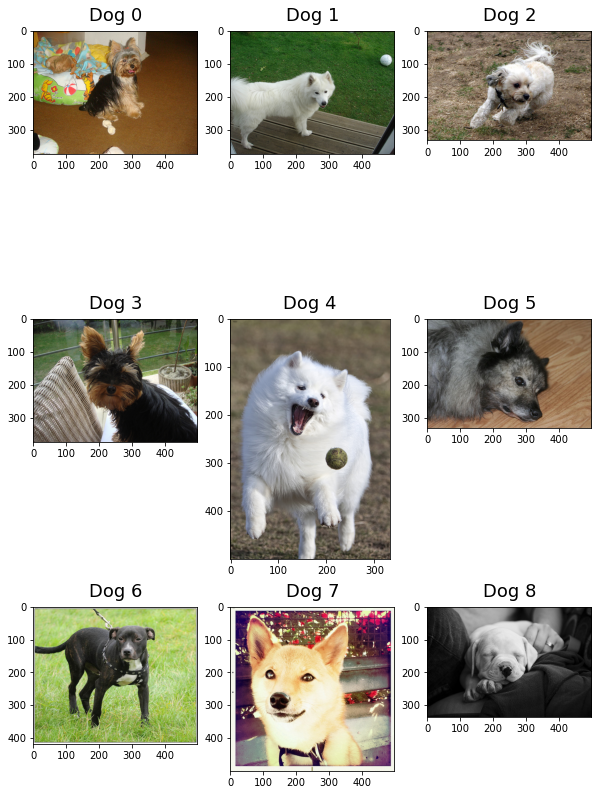

In [5]:
# Visualizando algumas imagens aleatorias da classe Dogs
dog_img_files = glob.glob('.\cats_and_dogs_dataset\\train\\dogs\\*')
random_dog_imgs = [cv2.imread(img_file) for img_file in random.sample(dog_img_files, 9)]
random_dog_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in random_dog_imgs]
titles = ['Dog ' + str(i) for i in range(9)]
showMultipleImages(random_dog_imgs, titles, (10, 15), 3, 3)

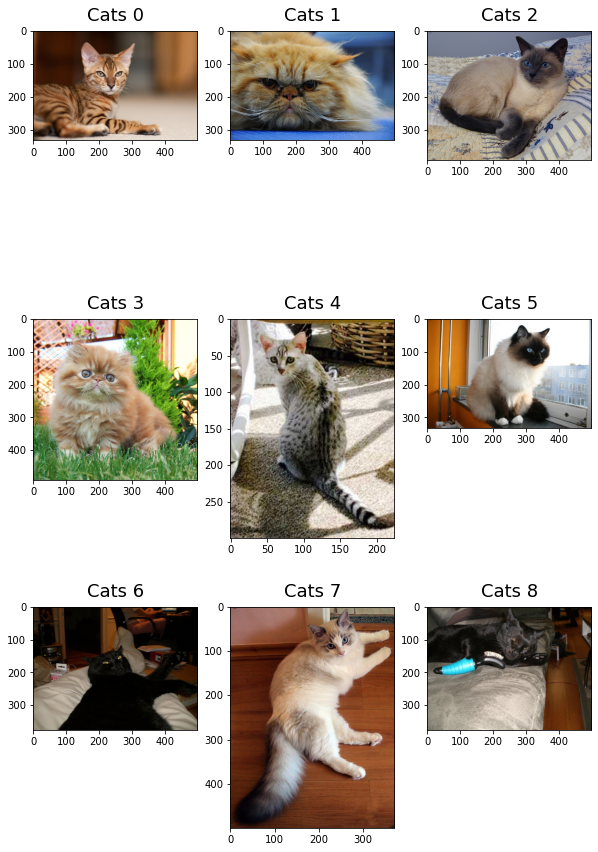

In [4]:
# Visualizando algumas imagens aleatorias da classe Cats
cat_img_files = glob.glob('.\cats_and_dogs_dataset\\train\\cats\\*')
random_dog_imgs = [cv2.imread(img_file) for img_file in random.sample(cat_img_files, 9)]
random_dog_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in random_dog_imgs]
titles = ['Cats ' + str(i) for i in range(9)]
showMultipleImages(random_dog_imgs, titles, (10, 15), 3, 3)

Observa-se que na base de dados temos imagens com 3 dimensões e 3 canais de cores. Apesar de serem de uma mesma classe, são muito diferentes umas das outras, apresentando várias posições, tamanhos e enfoques. O principal desafio é encontrar uma combinação de filtro que possa maximizar o ganho de informações a fim detectar as principais caracteristicas das duas classes.


## 2.1.2 Preparando os dados para o Random Florest

In [20]:
# Criação do treino
X_train = []
y_train = []
treino =  glob.glob('.\\cats_and_dogs_dataset\\train\\*\\*.jpg')
count = 0
for x in treino:
    img = cv2.imread(x)
    try :
        img.shape
    except:
        print(x)
    else:
        # Passando as imangens para tons de cinza
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Padronizando o tamanho da entrada
        img = cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA)
        # Equalização 
        clahe = cv2.createCLAHE(clipLimit= 2,tileGridSize=(3,3))
        cl1 = clahe.apply(img)
        img_eq = cv2.equalizeHist(cl1)
        
        X_train.append(img_eq)
        y_train.append(x.split('\\')[-2])

.\cats_and_dogs_dataset\train\cats\Abyssinian_34.jpg
.\cats_and_dogs_dataset\train\cats\Egyptian_Mau_139.jpg
.\cats_and_dogs_dataset\train\cats\Egyptian_Mau_177.jpg
.\cats_and_dogs_dataset\train\cats\Egyptian_Mau_191.jpg


In [21]:
# Criação da validação
X_val= []
y_val = []
validacao =  glob.glob('.\\cats_and_dogs_dataset\\validation\\*\\*.jpg')
count = 0
for x in validacao:
    img = cv2.imread(x)
    try :
        img.shape
    except:
        print(x)
    else:
        # Passando as imangens para tons de cinza
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Padronizando o tamanho da entrada
        img = cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA)
        # Equalização 
        clahe = cv2.createCLAHE(clipLimit= 2,tileGridSize=(3,3))
        cl1 = clahe.apply(img)
        img_eq = cv2.equalizeHist(cl1)
        
        X_val.append(img_eq)
        y_val.append(x.split('\\')[-2])

In [22]:
# Criação do teste
X_test= []
y_test = []
test =  glob.glob('.\\cats_and_dogs_dataset\\test\\*\\*.jpg')
count = 0
for x in test:
    img = cv2.imread(x)
    try :
        img.shape
    except:
        print(x)
    else:
       # Passando as imangens para tons de cinza
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Padronizando o tamanho da entrada
        img = cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA)
        # Equalização 
        clahe = cv2.createCLAHE(clipLimit= 2,tileGridSize=(3,3))
        cl1 = clahe.apply(img)
        img_eq = cv2.equalizeHist(cl1)
        
        X_test.append(img_eq)
        y_test.append(x.split('\\')[-2])

.\cats_and_dogs_dataset\test\cats\Egyptian_Mau_145.jpg
.\cats_and_dogs_dataset\test\cats\Egyptian_Mau_167.jpg


In [23]:
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_test = np.asarray(X_test)
print('tamanho do dataset de treino:', X_train.shape)
print('tamanho do dataset de validação:', X_val.shape)
print('tamanho do dataset de teste:', X_test.shape)

tamanho do dataset de treino: (5166, 64, 64)
tamanho do dataset de validação: (760, 64, 64)
tamanho do dataset de teste: (1458, 64, 64)


In [97]:
# Ajustando os dados para entrada no modelo
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_val_rf = X_val.reshape(X_val.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# 3. Modelos

## 3.1 Treinando o Random Florest

In [122]:
# Instanciando o modelo
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_rf, y_train) 


RandomForestClassifier(random_state=42)


Métricas de avaliação de treino:


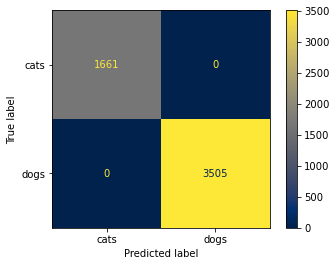

              precision    recall  f1-score   support

        cats       1.00      1.00      1.00      1661
        dogs       1.00      1.00      1.00      3505

    accuracy                           1.00      5166
   macro avg       1.00      1.00      1.00      5166
weighted avg       1.00      1.00      1.00      5166


Métricas de avaliação de teste:


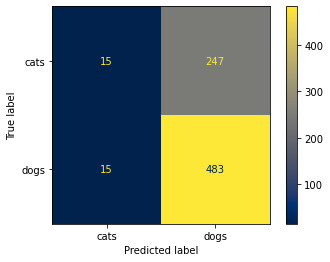

              precision    recall  f1-score   support

        cats       0.50      0.06      0.10       262
        dogs       0.66      0.97      0.79       498

    accuracy                           0.66       760
   macro avg       0.58      0.51      0.44       760
weighted avg       0.61      0.66      0.55       760



In [123]:
# Avaliação do modelo
metricas_classificacao(clf, X_train_rf, X_val_rf, y_train, y_val)

## 3.1.1 Ajuste do modelo

In [126]:
# Ajuste do modelo
params_distributions = {"n_estimators" : np.arange(100, 1501, 10), 
                        "max_depth" : np.arange(2, 9, 1)}
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rand_grid_rf = RandomizedSearchCV(clf, 
                                  params_distributions, 
                                  n_iter=20,
                                  cv=splitter,
                                  scoring="f1_weighted",
                                  verbose=10,
                                  random_state=42,
                                  return_train_score=True)
rand_grid_rf.fit(X_train_rf, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START max_depth=4, n_estimators=370..............................
[CV 1/5; 1/20] END max_depth=4, n_estimators=370;, score=(train=0.556, test=0.552) total time=  28.7s
[CV 2/5; 1/20] START max_depth=4, n_estimators=370..............................
[CV 2/5; 1/20] END max_depth=4, n_estimators=370;, score=(train=0.556, test=0.548) total time=  28.9s
[CV 3/5; 1/20] START max_depth=4, n_estimators=370..............................
[CV 3/5; 1/20] END max_depth=4, n_estimators=370;, score=(train=0.556, test=0.549) total time=  28.3s
[CV 4/5; 1/20] START max_depth=4, n_estimators=370..............................
[CV 4/5; 1/20] END max_depth=4, n_estimators=370;, score=(train=0.555, test=0.551) total time=  28.3s
[CV 5/5; 1/20] START max_depth=4, n_estimators=370..............................
[CV 5/5; 1/20] END max_depth=4, n_estimators=370;, score=(train=0.561, test=0.551) total time=  28.3s
[CV 1/5; 2/20] START ma

KeyboardInterrupt: 

In [127]:
# Instanciando o modelo com os melhores parametros encontrados
clf = RandomForestClassifier(max_depth=8, n_estimators=180, random_state=42)
clf.fit(X_train_rf, y_train)

RandomForestClassifier(max_depth=8, n_estimators=180, random_state=42)


Métricas de avaliação de treino:


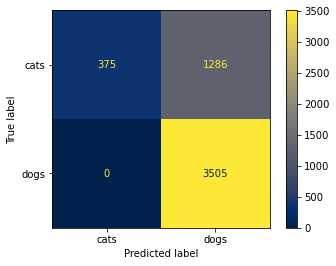

              precision    recall  f1-score   support

        cats       1.00      0.23      0.37      1661
        dogs       0.73      1.00      0.84      3505

    accuracy                           0.75      5166
   macro avg       0.87      0.61      0.61      5166
weighted avg       0.82      0.75      0.69      5166


Métricas de avaliação de teste:


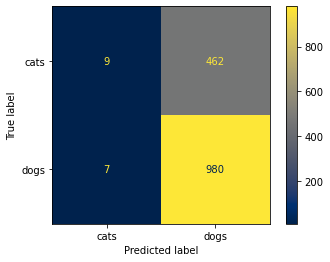

              precision    recall  f1-score   support

        cats       0.56      0.02      0.04       471
        dogs       0.68      0.99      0.81       987

    accuracy                           0.68      1458
   macro avg       0.62      0.51      0.42      1458
weighted avg       0.64      0.68      0.56      1458



In [128]:
#Avaliação do modelo
metricas_classificacao(clf, X_train_rf, X_test_rf, y_train, y_test)

## 3.2 Treinando a Rede

In [11]:
# Criaçao do dataset no padrão Keras
train_dataset = image_dataset_from_directory(train_folder,
                                             image_size=(180, 180),
                                             batch_size=32)

validation_dataset = image_dataset_from_directory(val_folder,
                                                  image_size=(180, 180),
                                                  batch_size=32)

test_dataset = image_dataset_from_directory(test_folder,
                                            image_size=(180, 180),
                                            batch_size=32)

Found 5170 files belonging to 2 classes.
Found 760 files belonging to 2 classes.
Found 1460 files belonging to 2 classes.


In [9]:
# visualização dos formato de 
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    print(data_batch[0].shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)
(180, 180, 3)


In [26]:
# Instanciando o modelo
model = keras.Sequential()
model.add(Rescaling(scale=1.0/255))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
# Metricas de aprendizado
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [27]:
# Treinando o modelo
callbacks = [
    ModelCheckpoint(
        filepath="model1.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/15
162/162 [==============================] - 307s 2s/step - loss: 0.6220 - accuracy: 0.6750 - val_loss: 0.6281 - val_accuracy: 0.6553
Epoch 2/15
162/162 [==============================] - 302s 2s/step - loss: 0.5682 - accuracy: 0.7027 - val_loss: 0.5878 - val_accuracy: 0.7474
Epoch 3/15
162/162 [==============================] - 302s 2s/step - loss: 0.5295 - accuracy: 0.7377 - val_loss: 0.5265 - val_accuracy: 0.7408
Epoch 4/15
162/162 [==============================] - 301s 2s/step - loss: 0.4636 - accuracy: 0.7787 - val_loss: 0.4207 - val_accuracy: 0.7961
Epoch 5/15
162/162 [==============================] - 302s 2s/step - loss: 0.3823 - accuracy: 0.8242 - val_loss: 0.3975 - val_accuracy: 0.8224
Epoch 6/15
162/162 [==============================] - 300s 2s/step - loss: 0.3249 - accuracy: 0.8574 - val_loss: 0.4159 - val_accuracy: 0.8368
Epoch 7/15
162/162 [==============================] - 302s 2s/step - loss: 0.2381 - accuracy: 0.8994 - val_loss: 0.4854 - val_accuracy: 0.8224

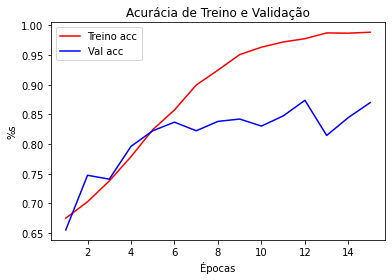

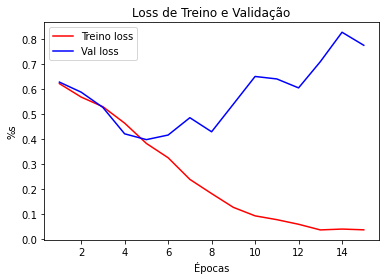

In [28]:
# Avalição do treino
avaliacao(history)

## 3.2.1 Aplicando o modelo

In [12]:
# Carregando o melhor modelo
model = keras.models.load_model("model1.keras")

In [13]:
# Aplicando os dados de teste no modelo e verificando sua performace 
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

46/46 [==============================] - 25s 522ms/step - loss: 0.3732 - accuracy: 0.8281
Test accuracy: 0.828


Observa-se que as redes neurais têm um poder maior de extrair informações sobre as imagens, talvez devido ao fato de que nas redes os algoritmos geram um volume maior de conjuntos de filtros, capazes de extrair melhor as características das classes; enquanto que no outro processo é preciso passar os filtros de forma singular, treinar e avaliar os ganhos diminuindo as chances de encontrar o conjunto ideal de filtros para melhor predição do modelo.

# 4. AVALIAÇÃO DAS RAÇAS

## 4.1 Preparando as pastas

In [47]:
# Pegando as labels 
dog_breed = []
cat_breed = []
    
for file in files:
    if file.split('\\')[-1].split('_')[0][0] == file.split('\\')[-1].split('_')[0][0].upper():
        if file.split('\\')[-1].split('_')[0] not in cat_breed:
            cat_breed.append(file.split('\\')[-1].split('_')[0])
    else:
        if len(file.split('\\')[-1].split('_')) > 2:
            if (file.split('\\')[-1].split('_')[0] + '_' + file.split('\\')[-1].split('_')[1]) not in dog_breed:
                dog_breed.append((file.split('\\')[-1].split('_')[0] + '_' + file.split('\\')[-1].split('_')[1]))
        else:    
            if file.split('\\')[-1].split('_')[0] not in dog_breed:
                dog_breed.append(file.split('\\')[-1].split('_')[0])

In [48]:
# Raças dos Gatos
cat_breed

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British',
 'Egyptian',
 'Maine',
 'Persian',
 'Ragdoll',
 'Russian',
 'Siamese',
 'Sphynx']

In [49]:
# Raças dos Cachorros
dog_breed

['american_bulldog',
 'american_pit',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull',
 'wheaten_terrier',
 'yorkshire_terrier']

In [4]:
# Criando variaveis para criação das pastas dogs
folder = "\\dogs_breed"
train_folder = current_dir + folder + "\\train"
val_folder = current_dir + folder + "\\validation"
test_folder = current_dir + folder + "\\test"

In [51]:
# Criando as pastas no formato do Keras
os.mkdir(current_dir + folder) 
os.mkdir(train_folder) 
os.mkdir(val_folder) 
os.mkdir(test_folder) 

for breed in dog_breed:
    new_folder_train_dogs = train_folder + f"\\{breed}"
    new_folder_val_dogs = val_folder + f"\\{breed}"
    new_folder_test_dogs = test_folder + f"\\{breed}"
    os.mkdir(new_folder_train_dogs)
    os.mkdir(new_folder_val_dogs)
    os.mkdir(new_folder_test_dogs)



In [52]:
# Criando variaveis para criação das pastas cats
folder = "\\cats_breed"
train_folder = current_dir + folder + "\\train"
val_folder = current_dir + folder + "\\validation"
test_folder = current_dir + folder + "\\test"

In [53]:
# Criando as pastas no formato do Keras
os.mkdir(current_dir + folder) 
os.mkdir(train_folder) 
os.mkdir(val_folder) 
os.mkdir(test_folder) 

for breed in cat_breed:
    new_folder_train_cats = train_folder + f"\\{breed}"
    new_folder_val_cats = val_folder + f"\\{breed}"
    new_folder_test_cats = test_folder + f"\\{breed}"
    os.mkdir(new_folder_train_cats)
    os.mkdir(new_folder_val_cats)
    os.mkdir(new_folder_test_cats)

In [56]:
# Movendo as imagens para as pasta que foram criadas já separando em treino, teste e validação
moveImagesToCorrectFolder2()
os.rmdir(original_path)

## 4.2 Dogs

## 4.2.1 Treinando a Rede

In [15]:
# Criaçao do dataset no padrão Keras
train_dog_dataset = image_dataset_from_directory('.\dogs_breed\\train',
                                             image_size=(180, 180),
                                             batch_size=32)

validation_dog_dataset = image_dataset_from_directory('.\dogs_breed\\validation',
                                                  image_size=(180, 180),
                                                  batch_size=32)

test_dog_dataset = image_dataset_from_directory('.\dogs_breed\\test',
                                            image_size=(180, 180),
                                            batch_size=32)

Found 3490 files belonging to 25 classes.
Found 500 files belonging to 25 classes.
Found 1000 files belonging to 25 classes.


In [18]:
# Instanciando o modelo
modeldog = keras.Sequential()
modeldog.add(Rescaling(scale=1.0/255))
modeldog.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
modeldog.add(MaxPooling2D(pool_size=(2, 2)))
modeldog.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
modeldog.add(MaxPooling2D(pool_size=(2, 2)))
modeldog.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
modeldog.add(MaxPooling2D(pool_size=(2, 2)))
modeldog.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
modeldog.add(MaxPooling2D(pool_size=(2, 2)))
modeldog.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
modeldog.add(MaxPooling2D(pool_size=(2, 2)))
modeldog.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
modeldog.add(Flatten())
modeldog.add(Dense(25, activation='softmax'))

# Metricas de avaliação do aprendizado
modeldog.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])

In [19]:
# Treinando e salvando o melhor modelo
callbacks = [
    ModelCheckpoint(
        filepath="modeldog2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

historydog = modeldog.fit(
    train_dog_dataset,
    epochs=10,
    validation_data=validation_dog_dataset,
    callbacks=callbacks)

Epoch 1/10
110/110 [==============================] - 201s 2s/step - loss: 3.2205 - accuracy: 0.0332 - val_loss: 3.2189 - val_accuracy: 0.0400
Epoch 2/10
110/110 [==============================] - 222s 2s/step - loss: 3.2194 - accuracy: 0.0352 - val_loss: 3.2189 - val_accuracy: 0.0400
Epoch 3/10
110/110 [==============================] - 227s 2s/step - loss: 3.2193 - accuracy: 0.0381 - val_loss: 3.2189 - val_accuracy: 0.0400
Epoch 4/10
110/110 [==============================] - 230s 2s/step - loss: 3.2192 - accuracy: 0.0338 - val_loss: 3.2189 - val_accuracy: 0.0400
Epoch 5/10
110/110 [==============================] - 228s 2s/step - loss: 3.2192 - accuracy: 0.0350 - val_loss: 3.2189 - val_accuracy: 0.0400
Epoch 6/10
110/110 [==============================] - 222s 2s/step - loss: 3.2192 - accuracy: 0.0381 - val_loss: 3.2189 - val_accuracy: 0.0400
Epoch 7/10
110/110 [==============================] - 202s 2s/step - loss: 3.2192 - accuracy: 0.0384 - val_loss: 3.2189 - val_accuracy: 0.0400

In [20]:
# Carregando o melhor modelo
model = keras.models.load_model("modeldog2.keras")
# Aplicando os dados de teste no modelo e verificando sua performace 
test_loss, test_acc = model.evaluate(test_dog_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 16s 472ms/step - loss: 3.2189 - accuracy: 0.0400
Test accuracy: 0.040


Como o resultado acima foi insatisfatório, aumentaremos o número de dados dos conjuntos de treino através das técnicas de translação, rotação e cisalhamento.  

In [98]:
# Percorrendo cada imagem do treino e gerando 3 novas imagens (rotated, shifted e sheared) e depois salvando 
files = [file for file in glob.glob('.\dogs_breed\\train\\*\\*.jpg')]
for file in files:
    label = file.split('\\')[3]
    name = file.split('\\')[-1].split('.')[0]
    img = cv2.imread(file)
    height, width, dim = img.shape
    center = (width/2, height/2)
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=45, scale=1)
    rotated_image = cv2.warpAffine(src=img, M=rotate_matrix, dsize=(width, height))
    
    M = np.float32([[1, 0, -30], [0, 1, -50]])
    shifted = cv2.warpAffine(img, M, (width, height))
    
    M = np.float32([[1,   0, 0],
                    [0.1, 1, 0],
                    [0,   0, 1]])
    
    sheared_img = cv2.warpPerspective(img,M,dsize=(width, height))
        
    cv2.imwrite('.\dogs_breed\\train\\' + label + '\\' + name + 'rotated' + '.jpg', rotated_image)
    cv2.imwrite('.\dogs_breed\\train\\' + label + '\\' + name + 'shifted' + '.jpg', shifted)
    cv2.imwrite('.\dogs_breed\\train\\' + label + '\\' + name + 'sheared' + '.jpg', sheared_img)

In [5]:
# Criaçao do dataset no padrão Keras
train_dog_dataset = image_dataset_from_directory('.\dogs_breed\\train',
                                             image_size=(180, 180),
                                             batch_size=32)

validation_dog_dataset = image_dataset_from_directory('.\dogs_breed\\validation',
                                                  image_size=(180, 180),
                                                  batch_size=32)

test_dog_dataset = image_dataset_from_directory('.\dogs_breed\\test',
                                            image_size=(180, 180),
                                            batch_size=32)

Found 13960 files belonging to 25 classes.
Found 500 files belonging to 25 classes.
Found 1000 files belonging to 25 classes.


In [7]:
# Instanciando o modelo
modeldog = keras.Sequential()
modeldog.add(Rescaling(scale=1.0/255))
modeldog.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
modeldog.add(MaxPooling2D(pool_size=(2, 2)))
modeldog.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
modeldog.add(MaxPooling2D(pool_size=(2, 2)))
modeldog.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
modeldog.add(MaxPooling2D(pool_size=(2, 2)))
modeldog.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
modeldog.add(MaxPooling2D(pool_size=(2, 2)))
modeldog.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
modeldog.add(MaxPooling2D(pool_size=(2, 2)))
modeldog.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
modeldog.add(Flatten())
modeldog.add(Dense(25, activation='softmax'))

# Metricas de avaliação do aprendizado
modeldog.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])

In [8]:
# Treinando e salvando o melhor modelo
callbacks = [
    ModelCheckpoint(
        filepath="modeldog1.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

historydog = modeldog.fit(
    train_dog_dataset,
    epochs=30,
    validation_data=validation_dog_dataset,
    callbacks=callbacks)

Epoch 1/30
437/437 [==============================] - 815s 2s/step - loss: 3.0591 - accuracy: 0.0917 - val_loss: 2.9250 - val_accuracy: 0.1280
Epoch 2/30
437/437 [==============================] - 793s 2s/step - loss: 2.7059 - accuracy: 0.1867 - val_loss: 2.6648 - val_accuracy: 0.2080
Epoch 3/30
437/437 [==============================] - 784s 2s/step - loss: 2.3330 - accuracy: 0.2891 - val_loss: 2.4850 - val_accuracy: 0.2820
Epoch 4/30
437/437 [==============================] - 787s 2s/step - loss: 1.9188 - accuracy: 0.4069 - val_loss: 2.4707 - val_accuracy: 0.3120
Epoch 5/30
437/437 [==============================] - 790s 2s/step - loss: 1.4886 - accuracy: 0.5346 - val_loss: 2.6690 - val_accuracy: 0.3480
Epoch 6/30
437/437 [==============================] - 787s 2s/step - loss: 1.0613 - accuracy: 0.6645 - val_loss: 3.2137 - val_accuracy: 0.3200
Epoch 7/30
437/437 [==============================] - 786s 2s/step - loss: 0.7108 - accuracy: 0.7670 - val_loss: 3.5626 - val_accuracy: 0.3280

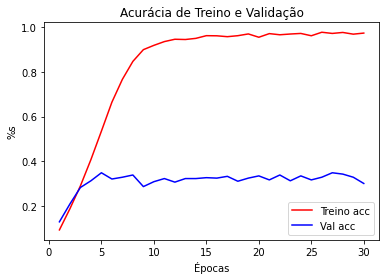

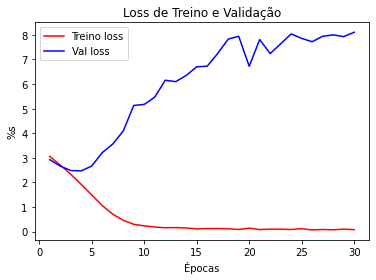

In [21]:
# Avaliação do treino
avaliacao(historydog)

## 4.2.2 Aplicando o modelo

In [10]:
# Carregando o melhor modelo
model = keras.models.load_model("modeldog1.keras")
# Aplicando os dados de teste no modelo e verificando sua performace
test_loss, test_acc = model.evaluate(test_dog_dataset)
print(f"Test accuracy: {test_acc:.3f}")


32/32 [==============================] - 16s 472ms/step - loss: 2.3693 - accuracy: 0.3290
Test accuracy: 0.329


Na análise realizada, foi possível observar que houve um ganho significativo no aprendizando, apesar de haver muito espaço para melhorias desse modelo por meio da utilização de mais dados e/ou de técnicas mais robustas.  A probabilidade de se acertar aleatoriamente a raça de determinado cachorro é de 1/25, ou seja, 4% e no entanto modelo apresentou uma taxa de acerto de 32,9%.

## 4.3 Cats

De forma analoga faremos os mesmos processos para predizer as raças do gatos

## 4.3.1 Treinando a Rede

In [115]:
# selecionando os arquivos
arquivos = [file for file in glob.glob('.\cats_breed\\train\\*\\*.jpg')]\
erro ='.\cats_breed\erro'

# Percorrendo cada imagem do treino e gerando 3 novas imagens (rotated, shifted e sheared) e depois salvando 
for arquivo in arquivos:
    label = arquivo.split('\\')[3]
    name = arquivo.split('\\')[-1].split('.')[0]
    img = cv2.imread(arquivo)
    try :
        img.shape
    except:
        shutil.move(arquivo, erro)
    else:    
        height, width, dim = img.shape
        center = (width/2, height/2)
        rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=45, scale=1)
        rotated_image = cv2.warpAffine(src=img, M=rotate_matrix, dsize=(width, height))
        
        M = np.float32([[1, 0, -30], [0, 1, -50]])
        shifted = cv2.warpAffine(img, M, (width, height))
        
        M = np.float32([[1,   0, 0],
                        [0.1, 1, 0],
                        [0,   0, 1]])
        
        sheared_img = cv2.warpPerspective(img,M,dsize=(width, height))
            
        cv2.imwrite('.\cats_breed\\train\\' + label + '\\' + name + 'rotated' + '.jpg', rotated_image)
        cv2.imwrite('.\cats_breed\\train\\' + label + '\\' + name + 'shifted' + '.jpg', shifted)
        cv2.imwrite('.\cats_breed\\train\\' + label + '\\' + name + 'sheared' + '.jpg', sheared_img)

In [11]:
# Criaçao do dataset no padrão Keras
train_cat_dataset = image_dataset_from_directory('.\cats_breed\\train',
                                             image_size=(180, 180),
                                             batch_size=32)

validation_cat_dataset = image_dataset_from_directory('.\cats_breed\\validation',
                                                  image_size=(180, 180),
                                                  batch_size=32)

test_cat_dataset = image_dataset_from_directory('.\cats_breed\\test',
                                            image_size=(180, 180),
                                            batch_size=32)

Found 6711 files belonging to 12 classes.
Found 239 files belonging to 12 classes.
Found 480 files belonging to 12 classes.


In [12]:
# Instanciando o modelo
modelcat = keras.Sequential()
modelcat.add(Rescaling(scale=1.0/255))
modelcat.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
modelcat.add(MaxPooling2D(pool_size=(2, 2)))
modelcat.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
modelcat.add(MaxPooling2D(pool_size=(2, 2)))
modelcat.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
modelcat.add(MaxPooling2D(pool_size=(2, 2)))
modelcat.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
modelcat.add(MaxPooling2D(pool_size=(2, 2)))
modelcat.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
modelcat.add(Flatten())
modelcat.add(Dense(12, activation="softmax"))

# Metricas de avaliação do aprendizado
modelcat.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])

In [13]:
# Treinando e salvando o melhor modelo
callbacks = [
    ModelCheckpoint(
        filepath="modelcat2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

historycat = modelcat.fit(
    train_cat_dataset,
    epochs=25,
    validation_data=validation_cat_dataset,
    callbacks=callbacks)

Epoch 1/25
210/210 [==============================] - 362s 2s/step - loss: 2.2519 - accuracy: 0.2058 - val_loss: 2.2071 - val_accuracy: 0.2218
Epoch 2/25
210/210 [==============================] - 357s 2s/step - loss: 1.9365 - accuracy: 0.3333 - val_loss: 2.0282 - val_accuracy: 0.2971
Epoch 3/25
210/210 [==============================] - 358s 2s/step - loss: 1.6523 - accuracy: 0.4306 - val_loss: 1.7715 - val_accuracy: 0.3515
Epoch 4/25
210/210 [==============================] - 360s 2s/step - loss: 1.3778 - accuracy: 0.5150 - val_loss: 1.7081 - val_accuracy: 0.4268
Epoch 5/25
210/210 [==============================] - 357s 2s/step - loss: 1.1444 - accuracy: 0.6024 - val_loss: 1.7255 - val_accuracy: 0.4435
Epoch 6/25
210/210 [==============================] - 358s 2s/step - loss: 0.8880 - accuracy: 0.6945 - val_loss: 1.9919 - val_accuracy: 0.4142
Epoch 7/25
210/210 [==============================] - 358s 2s/step - loss: 0.6605 - accuracy: 0.7720 - val_loss: 2.2190 - val_accuracy: 0.4393

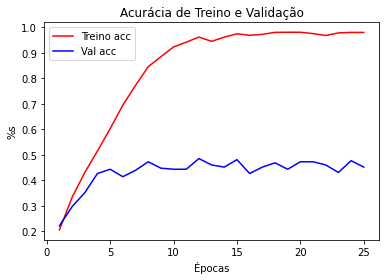

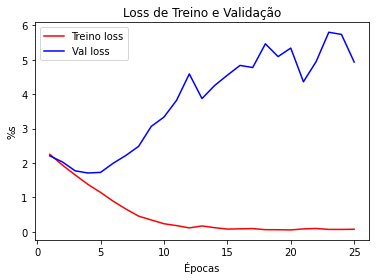

In [22]:
# Avaliação do treino
avaliacao(historycat)

## 4.3.2 Aplicando o modelo

In [15]:
# Carregando o melhor modelo
model = keras.models.load_model("modelcat2.keras")

# Aplicando os dados de teste no modelo e verificando sua performace 
test_loss, test_acc = model.evaluate(test_cat_dataset)
print(f"Test accuracy: {test_acc:.3f}")

15/15 [==============================] - 8s 466ms/step - loss: 1.6055 - accuracy: 0.4854
Test accuracy: 0.485


Na análise realizada, modelo apresentou um resultado de acurácia de 48,5%, um número 4 vezes maior que a probalidade de acertamos a raça de um gato aleatoriamente, que é 1/9, ou seja, 11,2%.